In [72]:
import operator
from pprint import pprint
import itertools

from SolrClient import SolrClient

import gensim
from gensim.models import CoherenceModel, LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import matutils

import pyLDAvis.gensim

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from treetagger import TreeTagger

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pedro.castro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [3]:
solr = SolrClient('http://192.168.200.201:8080/easysearch')

In [4]:
res = solr.query('default',{
            'q': '-ctr_id:id_document_spell',
            'indent': 'true',
            'fl': 'ctr_id,api_Nome_do_arquivo_tg,api_Conteúdo_tg,api_Título_tg',
            'wt': 'json',
            'rows': '2147483647'
    })

In [5]:
res.get_results_count()

3387

In [6]:
res.docs[0]

{'api_Conteúdo_tg': 'A Pró-Reitora de Gestão e Desenvolvimento de Pessoas da\nUniversidade Federal de São João del-Rei - UFSJ, no uso de suas\natribuições, HOMOLOGA o concurso público para provimento de\ncargo da Carreira de Magistério Superior, CPD 051/2016, na área de\nDERMATOLOGIA, para o Departamento de Medicina (DEMED),\nEdital publicado no DOU do dia 01/08/2016 e torna público seu\nresultado, a saber: 1º LUGAR: VALÉRIA AZEVEDO JUNQUEIRA;\n2° LUGAR: MAHYRA LEITE RIBEIRO.\nEm 28 de setembro de 2016',
 'api_Nome_do_arquivo_tg': 'DO3_2016_09_29_1001.xml',
 'api_Título_tg': 'EDITAL DE HOMOLOGAÇÃO CPD Nº 51/2016',
 'ctr_id': 'da77343019c27110cf9ace0925c6b35cdae2cd6a'}

In [7]:
res.docs[0]['api_Conteúdo_tg']

'A Pró-Reitora de Gestão e Desenvolvimento de Pessoas da\nUniversidade Federal de São João del-Rei - UFSJ, no uso de suas\natribuições, HOMOLOGA o concurso público para provimento de\ncargo da Carreira de Magistério Superior, CPD 051/2016, na área de\nDERMATOLOGIA, para o Departamento de Medicina (DEMED),\nEdital publicado no DOU do dia 01/08/2016 e torna público seu\nresultado, a saber: 1º LUGAR: VALÉRIA AZEVEDO JUNQUEIRA;\n2° LUGAR: MAHYRA LEITE RIBEIRO.\nEm 28 de setembro de 2016'

In [8]:
def preprocess_texts(texts, text_field):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    for text in texts:
        yield gensim.utils.simple_preprocess(text[text_field], deacc=False, min_len=3)

In [9]:
train_texts = list(preprocess_texts(res.docs, 'api_Conteúdo_tg'))

In [10]:
def lemmatize(text, language='portuguese'):
    tt = TreeTagger(language=language)
    lemmas = tt.tag(text)
    return [tuples[0] if tuples[2] == '<unknown>' else tuples[2] for tuples in lemmas]
print(lemmatize('Olá, tudo bem com vocês?'))

['olá', ',', 'tudo', 'bem', 'com', 'você', '?']


In [11]:
def lemmatize_texts(texts, language='portuguese'):
    lemmatized = []
    for idx, line in enumerate(texts):
        if idx % 100 == 0:
            logging.log(msg='line ' + str(idx), level=logging.INFO)
        lemmas = lemmatize(line, language=language)
        lemmatized.append([word for word in lemmas])
    return lemmatized

In [12]:
def process_texts(texts, language='portuguese'):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    stops = set(stopwords.words(language))
    #texts = [[word for word in word_tokenize(text) if word.lower() not in stops] for text in texts]
    #print('pós stopwords', texts)
    texts = [[word for word in text if word not in stops] for text in texts]
    
    #texts = [[word for word in lemmatize(line, language=language)] for line in texts]
    texts = lemmatize_texts(texts, language=language)
    
    phrases = gensim.models.Phrases(texts)
    bigram = gensim.models.phrases.Phraser(phrases)
    
    for idx in range(len(texts)):
        for token in bigram[texts[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                texts[idx].append(token)
    
    return texts

In [13]:
%%time
train_texts = process_texts(train_texts)

CPU times: user 7.22 s, sys: 24.3 s, total: 31.5 s
Wall time: 27min 16s


In [14]:
train_texts[0]

['pró',
 'reitor',
 'gestão',
 'desenvolvimento',
 'pessoa',
 'universidade',
 'federal',
 'joão',
 'del',
 'rei',
 'ufsj',
 'uso',
 'atribuição',
 'homologar',
 'concurso',
 'público',
 'provimento',
 'cargo',
 'carreira',
 'magistério',
 'superior',
 'cpd',
 'área',
 'dermatologia',
 'departamento',
 'medicina',
 'demed',
 'edital',
 'publicar',
 'dar',
 'dia',
 'tornar',
 'público',
 'resultado',
 'saber',
 'lugar',
 'valéria',
 'azevedo',
 'junqueira',
 'lugar',
 'mahyra',
 'leite',
 'ribeiro',
 'setembro',
 'pró_reitor',
 'desenvolvimento_pessoa',
 'universidade_federal',
 'joão_del',
 'rei_ufsj',
 'uso_atribuição',
 'concurso_público',
 'carreira_magistério',
 'superior_cpd',
 'departamento_medicina',
 'demed_edital',
 'publicar_dar',
 'tornar_público']

In [15]:
dictionary = Dictionary(train_texts)

In [16]:
print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 23271


In [17]:
dictionary.save('dictionary_full.dict')

In [18]:
dictionary_filtered = Dictionary(train_texts)
dictionary_filtered.save('dictionary_filtered.dict')
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=20, no_above=0.5)
dictionary_filtered.filter_extremes(no_above=0.5)
print('Number of unique tokens: %d' % len(dictionary_filtered))

Number of unique tokens: 6449


In [19]:
corpus = [dictionary.doc2bow(text) for text in train_texts]
print('Number of documents on full: %d' % len(corpus))
corpus_filtered = [dictionary_filtered.doc2bow(text) for text in train_texts]
print('Number of documents on filtered: %d' % len(corpus_filtered))

Number of documents on full: 3387
Number of documents on filtered: 3387


In [20]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
ldamodel_filtered = LdaModel(corpus=corpus_filtered, num_topics=10, id2word=dictionary_filtered)

In [22]:
pyLDAvis.enable_notebook()

In [23]:
pyLDAvis.gensim.prepare(ldamodel_filtered, corpus_filtered, dictionary_filtered)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      19.444476        1       1  0.112252 -0.032548
6      17.334985        1       2  0.047305 -0.010828
9      12.841473        1       3  0.010536 -0.064968
3      11.900771        1       4  0.142295  0.022973
8       8.414729        1       5 -0.124552 -0.015245
5       6.619919        1       6 -0.123982  0.030917
4       6.438078        1       7  0.028102  0.113876
1       6.416267        1       8 -0.039429 -0.074119
7       6.146198        1       9 -0.000402 -0.020224
2       4.443104        1      10 -0.052124  0.050167, topic_info=     Category         Freq                Term        Total  loglift  logprob
term                                                                         
2450  Default   981.000000               turma   981.000000  30.0000  30.0000
2582  Default  1133.000000                 adv  1133.000000  29.0000  29.0000
2862  Default   648.000000           incidente   648.000000  28.0000  28.0000
4259  Default   753.000000      turma_recursal   753.000000  27.0000  27.0000
4088  Default   664.000000                 oab   664.000000  26.0000  26.0000
87    Default  1859.000000                item  1859.000000  25.0000  25.0000
3754  Default   537.000000               negar   537.000000  24.0000  24.0000
973   Default  1032.000000               siape  1032.000000  23.0000  23.0000
3447  Default   670.000000          requerente   670.000000  22.0000  22.0000
4913  Default   416.000000             acórdão   416.000000  21.0000  21.0000
5514  Default  1088.000000       uniformização  1088.000000  20.0000  20.0000
5209  Default   631.000000        resolver_art   631.000000  19.0000  19.0000
2157  Default   969.000000                proc   969.000000  18.0000  18.0000
4304  Default   333.000000    seção_judiciário   333.000000  17.0000  17.0000
6     Default  2435.000000             federal  2435.000000  16.0000  16.0000
1639  Default   809.000000              origem   809.000000  15.0000  15.0000
17    Default  1033.000000               cargo  1033.000000  14.0000  14.0000
785   Default  1400.000000            nacional  1400.000000  13.0000  13.0000
93    Default  1891.000000                ltda  1891.000000  12.0000  12.0000
4032  Default   316.000000    negar_provimento   316.000000  11.0000  11.0000
4120  Default   418.000000             juizado   418.000000  10.0000  10.0000
628   Default   889.000000               seção   889.000000   9.0000   9.0000
3980  Default   471.000000          judiciário   471.000000   8.0000   8.0000
181   Default   899.000000                 www   899.000000   7.0000   7.0000
182   Default   813.000000                 gov   813.000000   6.0000   6.0000
27    Default  1612.000000            publicar  1612.000000   5.0000   5.0000
5159  Default   239.000000            ocupante   239.000000   4.0000   4.0000
5     Default   830.000000        universidade   830.000000   3.0000   3.0000
5545  Default   574.000000              agravo   574.000000   2.0000   2.0000
16    Default   545.000000          provimento   545.000000   1.0000   1.0000
...       ...          ...                 ...          ...      ...      ...
5137  Topic10    48.890986              súmula   154.655681   1.9622  -5.8329
3980  Topic10   122.246218          judiciário   471.366357   1.7642  -4.9165
4132  Topic10    71.326804    juizado_especial   306.616867   1.6555  -5.4552
3191  Topic10    34.826893  procuradoria_geral   121.704414   1.8626  -6.1721
3183  Topic10    88.986345        procuradoria   424.002988   1.5526  -5.2340
4773  Topic10    25.477798              trazer    86.278226   1.8940  -6.4847
1639  Topic10   114.006726              origem   809.941843   1.1531  -4.9862
2157  Topic10   120.936109                proc   969.636752   1.0322  -4.9272
785   Topic10   152.132969            nacional  1400.663964   0.8939  -4.6977
617   Topic10    66.005156       

In [24]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      15.402235        1       1 -0.101479 -0.026985
9      14.959314        1       2  0.153046 -0.036267
6      11.668403        1       3 -0.158875  0.041032
4      11.589136        1       4  0.122508  0.049912
7      10.822594        1       5  0.007015 -0.040484
3      10.103162        1       6 -0.030085 -0.037530
8       9.352915        1       7 -0.012867 -0.096831
0       5.704538        1       8  0.016773  0.051552
1       5.682897        1       9 -0.022051  0.046317
2       4.714805        1      10  0.026014  0.049283, topic_info=      Category         Freq              Term        Total  loglift  logprob
term                                                                        
5342   Default   778.000000         incidente   778.000000  30.0000  30.0000
4477   Default  1077.000000             turma  1077.000000  29.0000  29.0000
1608   Default   611.000000            prover   611.000000  28.0000  28.0000
10816  Default   484.000000           acórdão   484.000000  27.0000  27.0000
6604   Default   839.000000        requerente   839.000000  26.0000  26.0000
8313   Default   461.000000    turma_recursal   461.000000  25.0000  25.0000
8050   Default   673.000000               oab   673.000000  24.0000  24.0000
104    Default  2265.000000              ltda  2265.000000  23.0000  23.0000
589    Default  4131.000000               art  4131.000000  22.0000  22.0000
4741   Default   640.000000               adv   640.000000  21.0000  21.0000
6      Default  2243.000000           federal  2243.000000  20.0000  20.0000
343    Default  1922.000000              cnpj  1922.000000  19.0000  19.0000
96     Default  1939.000000              item  1939.000000  18.0000  18.0000
394    Default  2018.000000             valor  2018.000000  17.0000  17.0000
6380   Default   616.000000          recursal   616.000000  16.0000  16.0000
1203   Default   889.000000             siape   889.000000  15.0000  15.0000
7253   Default   433.000000             negar   433.000000  14.0000  14.0000
17709  Default   977.000000     uniformização   977.000000  13.0000  13.0000
2702   Default   887.000000            fiscal   887.000000  12.0000  12.0000
233    Default  1144.000000               www  1144.000000  11.0000  11.0000
234    Default  1027.000000               gov  1027.000000  10.0000  10.0000
55     Default  3287.000000          processo  3287.000000   9.0000   9.0000
13006  Default   260.000000            súmula   260.000000   8.0000   8.0000
8091   Default   466.000000           juizado   466.000000   7.0000   7.0000
2790   Default   733.000000            origem   733.000000   6.0000   6.0000
8412   Default   362.000000  seção_judiciário   362.000000   5.0000   5.0000
223    Default  1269.000000             total  1269.000000   4.0000   4.0000
2955   Default   522.000000            contra   522.000000   3.0000   3.0000
7892   Default   211.000000  negar_provimento   211.000000   2.0000   2.0000
238    Default   768.000000              site   768.000000   1.0000   1.0000
...        ...          ...               ...          ...      ...      ...
4081   Topic10    40.465481        seguimento   118.207368   1.9825  -6.2170
527    Topic10    45.026054          cancelar   141.158342   1.9118  -6.1102
14513  Topic10    13.643530            gaúcho    28.355521   2.3229  -7.3041
12310  Topic10    15.259907          presença    33.811323   2.2589  -7.1922
6683   Topic10    41.434230     possibilidade   155.141758   1.7342  -6.1933
752    Topic10    67.284032               ora   356.822831   1.3861  -5.7085
6654   Topic10    78.630417              inss   478.869052   1.2478  -5.5526
55     Topic10   255.000260          processo  3287.856508   0.4977  -4.3761
4477   Topic10   111.660296             turma  1077.909221   0.7871  -5.2019
7253   Topic10    64.366280             negar   433.825934   1.1464  -5.752

In [74]:
def get_best_model_by_topics(dictionary, corpus, texts, limit, iterations=400):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    # Set training parameters.
    chunksize = 4000
    passes = 20
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    
    lm_list = {}
    co_va = {}
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, id2word=dictionary, passes=passes, \
                      num_topics=num_topics, chunksize=chunksize, iterations=iterations, \
                      eval_every=eval_every, alpha='auto', eta='auto')
        lm_list[num_topics - 1] = lm
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        co_va[num_topics - 1] = cm.get_coherence()
    top_models = sorted(co_va.items(), key=operator.itemgetter(1), reverse=True)
    print('Melhores 5 modelos', top_models[:5])
    return lm_list[top_models[0][0]], lm_list, co_va

In [75]:
%%time
best_model_full, lm_full, c_v_full = get_best_model_by_topics(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=10)
print(best_model_full.show_topics(formatted=True))

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(4, 0.76432217736486474), (7, 0.70503843435773883), (8, 0.70503079178044814), (3, 0.70132018267725527), (5, 0.68009697596114371)]
[(0, '0.016*"www" + 0.015*"gov" + 0.014*"edital" + 0.011*"site" + 0.010*"propor" + 0.008*"processo" + 0.008*"eletrônico" + 0.008*"pregão" + 0.008*"comprasnet" + 0.006*"abertura"'), (1, '0.014*"uniformização" + 0.013*"turma" + 0.011*"federal" + 0.010*"nacional" + 0.009*"adv" + 0.009*"proc" + 0.009*"requerente" + 0.009*"decisão" + 0.009*"parte" + 0.008*"origem"'), (2, '0.013*"art" + 0.010*"processo" + 0.006*"publicar" + 0.006*"dia" + 0.006*"uso" + 0.006*"federal" + 0.006*"lei" + 0.005*"resolver" + 0.005*"portar" + 0.005*"portaria"'), (3, '0.015*"valor" + 0.014*"contratar" + 0.013*"cnpj" + 0.012*"lei" + 0.011*"contrato" + 0.011*"ltda" + 0.010*"processo" + 0.010*"vigência" + 0.009*"assinatura" + 0.009*"datar"'), (4, '0.016*"item" + 0.014*"ltda" + 0.011*"valor" + 0.010*"ecf" + 0.009*"dever" + 0.009*"ser" + 0.006*"fiscal" + 0.006*"empresa" + 0.

In [76]:
%%time
best_model_filtered, lm_filtered, c_v_filtered = get_best_model_by_topics(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=10)
print(best_model_filtered.show_topics(formatted=True))

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(3, 0.81050511593096619), (4, 0.78821549649132916), (6, 0.78725867513081116), (7, 0.74918946107556372), (8, 0.73772382812187387)]
[(0, '0.018*"edital" + 0.017*"www" + 0.015*"gov" + 0.011*"site" + 0.010*"propor" + 0.009*"pregão" + 0.009*"licitação" + 0.009*"item" + 0.009*"eletrônico" + 0.008*"comprasnet"'), (1, '0.018*"valor" + 0.016*"ltda" + 0.015*"cnpj" + 0.011*"contratar" + 0.009*"contrato" + 0.009*"lei" + 0.008*"serviço" + 0.008*"assinatura" + 0.008*"item" + 0.008*"vigência"'), (2, '0.015*"uniformização" + 0.014*"turma" + 0.013*"federal" + 0.011*"adv" + 0.010*"nacional" + 0.010*"proc" + 0.010*"decisão" + 0.010*"requerente" + 0.010*"parte" + 0.009*"origem"'), (3, '0.021*"art" + 0.008*"uso" + 0.008*"publicar" + 0.008*"lei" + 0.008*"federal" + 0.008*"resolver" + 0.007*"portar" + 0.007*"cargo" + 0.007*"código" + 0.007*"inciso"')]
CPU times: user 12min 31s, sys: 1.26 s, total: 12min 33s
Wall time: 12min 47s


In [87]:
# Build topic listings from each model.
def top_topics(lda, num_words=20):
    str_topics = []
    for topic in lda.state.get_lambda():
        topic = topic / topic.sum()  # normalize to probability distribution
        bestn = matutils.argsort(topic, topn=num_words, reverse=True)
        beststr = [lda.id2word[_id] for _id in bestn]
        str_topics.append(beststr)
    return str_topics

def get_super_topic(trained_models):
    model_topics = {}
    super_topic = set()
    for num_topics, model in trained_models.items():
        topics_as_topn_terms = top_topics(model)
        model_topics[num_topics] = topics_as_topn_terms
        super_topic.update(itertools.chain.from_iterable(topics_as_topn_terms))
    print("Number of relevant terms: %d" % len(super_topic))
    return super_topic, model_topics

In [88]:
super_topic, model_topics = get_super_topic(lm_filtered)
print(super_topic)

Number of relevant terms: 184
{'dever', 'tratar', 'vigência', 'campus', 'social', 'objetar', 'documento', 'contratar', 'siape', 'mil', 'requisito', 'real', 'instituto', 'item', 'educação', 'mês', 'fiscal', 'resolução', 'epp', 'resolver', 'origem', 'inciso', 'prova', 'diretoria', 'legal', 'emitir', 'proc', 'publicar', 'contrato', 'número', 'ambiental', 'turma_recursal', 'conforme', 'aquisição', 'entregar', 'rdc', 'contratante', 'requerente', 'eireli', 'diretor', 'anexo', 'adv', 'global', 'junho', 'proc_adv', 'acórdão', 'uso_atribuição', 'cpf', 'dia', 'este', 'fundamento_legal', 'art_portaria', 'ltda_epp', 'cnpj', 'juizado', 'empresa', 'informar', 'pessoal', 'comerciar', 'datar_assinatura', 'registro', 'www', 'gov', 'geral', 'benefício', 'judiciário', 'município', 'diário', 'saúde', 'sidec', 'atar', 'tornar', 'art', 'poder', 'municipal', 'seção', 'termo', 'inss', 'partir', 'portaria', 'ltda_cnpj', 'abertura', 'valor', 'contra', 'tornar_público', 'página', 'universidade', 'propor', 'turma

In [85]:
%%time
# Now estimate the probabilities for the CoherenceModel

cm = CoherenceModel(
    topics=[super_topic], texts=train_texts,
    dictionary=dictionary_filtered, coherence='c_v')
cm.estimate_probabilities()

CPU times: user 224 ms, sys: 68 ms, total: 292 ms
Wall time: 3.56 s


In [89]:
%%time
import numpy as np
# Next we perform the coherence evaluation for each of the models.
# Since we have already precomputed the probabilities, this simply
# involves using the accumulated stats in the `CoherenceModel` to
# perform the evaluations, which should be pretty quick.

coherences = {}
for num_topics, topics in model_topics.items():
    cm.topics = topics

    # We evaluate at various values of N and average them. This is a more robust,
    # according to: http://people.eng.unimelb.edu.au/tbaldwin/pubs/naacl2016.pdf
    coherence_at_n = {}
    for n in (20, 15, 10, 5):
        cm.topn = n
        topic_coherences = cm.get_coherence_per_topic()
        
        # Let's record the coherences for each topic, as well as the aggregated
        # coherence across all of the topics.
        coherence_at_n[n] = (topic_coherences, cm.aggregate_measures(topic_coherences))
        
    topic_coherences, avg_coherences = zip(*coherence_at_n.values())
    avg_topic_coherences = np.vstack(topic_coherences).mean(0)
    avg_coherence = np.mean(avg_coherences)
    print("Avg coherence for num_topics=%d: %.5f" % (num_topics, avg_coherence))
    coherences[num_topics] = (avg_topic_coherences, avg_coherence)

Avg coherence for num_topics=0: 0.41268
Avg coherence for num_topics=1: 0.59604
Avg coherence for num_topics=2: 0.67527
Avg coherence for num_topics=3: 0.76075
Avg coherence for num_topics=4: 0.74067
Avg coherence for num_topics=5: 0.63496
Avg coherence for num_topics=6: 0.73725
Avg coherence for num_topics=7: 0.69187
Avg coherence for num_topics=8: 0.71889
CPU times: user 8.4 s, sys: 36 ms, total: 8.44 s
Wall time: 8.35 s


In [62]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = {}
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=4000, \
                      eta='auto', alpha='auto', eval_every=None)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v[num_topics-1] = cm.get_coherence()
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, list(c_v.values()))
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


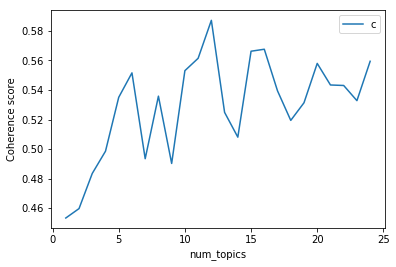

CPU times: user 4min 57s, sys: 28.4 s, total: 5min 26s
Wall time: 5min 20s


In [63]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=25)

In [67]:
print(c_v)
print(sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0])

{0: 0.45339179550202069, 1: 0.45976001824810664, 2: 0.48353875308045463, 3: 0.498591190663071, 4: 0.53505638745288653, 5: 0.55160130572583055, 6: 0.4935118851988462, 7: 0.53584008054360577, 8: 0.49031243457702889, 9: 0.5530901622372455, 10: 0.56145128896048535, 11: 0.58714553255414581, 12: 0.52486810527802841, 13: 0.50809748956926548, 14: 0.56624916270803993, 15: 0.56758982019001059, 16: 0.53941702736657526, 17: 0.51944448005651067, 18: 0.53137507258154149, 19: 0.55800093908063952, 20: 0.54340438054408491, 21: 0.54306344496117365, 22: 0.53279476511547574, 23: 0.55944813428995599}
11


In [68]:
pyLDAvis.gensim.prepare(lmlist[sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0]], corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      15.593189        1       1  0.037568  0.004704
10     12.937517        1       2  0.020036 -0.024756
5      11.192822        1       3 -0.059331  0.032098
8      10.830755        1       4  0.053333  0.006389
0       8.510518        1       5  0.055011  0.052193
9       8.224192        1       6 -0.044013 -0.036612
7       7.372090        1       7  0.011594 -0.028947
1       6.625948        1       8  0.038793 -0.011915
2       5.625803        1       9 -0.025376  0.011555
11      5.281995        1      10 -0.070621  0.013523
4       4.461802        1      11  0.018133 -0.022417
6       3.343369        1      12 -0.035127  0.004186, topic_info=      Category         Freq              Term        Total  loglift  logprob
term                                                                        
589    Default  3297.000000               art  3297.000000  30.0000  30.0000
17709  Default   888.000000     uniformização   888.000000  29.0000  29.0000
4477   Default   822.000000             turma   822.000000  28.0000  28.0000
104    Default  2050.000000              ltda  2050.000000  27.0000  27.0000
233    Default  1337.000000               www  1337.000000  26.0000  26.0000
96     Default  1710.000000              item  1710.000000  25.0000  25.0000
1659   Default   923.000000            código   923.000000  24.0000  24.0000
410    Default   698.000000             parte   698.000000  23.0000  23.0000
6      Default  2084.000000           federal  2084.000000  22.0000  22.0000
234    Default  1166.000000               gov  1166.000000  21.0000  21.0000
4741   Default   599.000000               adv   599.000000  20.0000  20.0000
4735   Default   261.000000              ipro   261.000000  19.0000  19.0000
16032  Default   237.000000               fts   237.000000  18.0000  18.0000
344    Default  1288.000000         contratar  1288.000000  17.0000  17.0000
3924   Default   638.000000              proc   638.000000  16.0000  16.0000
256    Default   519.000000          site_www   519.000000  15.0000  15.0000
6604   Default   574.000000        requerente   574.000000  14.0000  14.0000
257    Default   378.000000    comprasnet_gov   378.000000  13.0000  13.0000
18069  Default   461.000000            agravo   461.000000  12.0000  12.0000
394    Default  2315.000000             valor  2315.000000  11.0000  11.0000
239    Default   588.000000        comprasnet   588.000000  10.0000  10.0000
337    Default  1086.000000          contrato  1086.000000   9.0000   9.0000
5342   Default   463.000000         incidente   463.000000   8.0000   8.0000
28     Default  1315.000000          publicar  1315.000000   7.0000   7.0000
238    Default   888.000000              site   888.000000   6.0000   6.0000
391    Default  2130.000000               lei  2130.000000   5.0000   5.0000
236    Default   816.000000            propor   816.000000   4.0000   4.0000
1203   Default   657.000000             siape   657.000000   3.0000   3.0000
4859   Default   678.000000           decisão   678.000000   2.0000   2.0000
55     Default  3190.000000          processo  3190.000000   1.0000   1.0000
...        ...          ...               ...          ...      ...      ...
8109   Topic12    17.281620  juizado_especial   192.376280   0.9884  -6.7240
427    Topic12    42.294893           recurso   894.887853   0.3462  -5.8290
3924   Topic12    34.503951              proc   638.191089   0.4806  -6.0326
211    Topic12    56.087383           serviço  1507.498753   0.1069  -5.5468
1940   Topic12    16.374517            efeito   184.548571   0.9760  -6.7780
580    Topic12    29.336024            número   530.569748   0.5031  -6.1949
6      Topic12    62.284875           federal  2084.019662  -0.1121  -5.4420
1228   Topic12    24.793371         relatório   409.354661   0.5942  -6.3631
5342   Topic12    26.354278         incident

/media/discoD/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


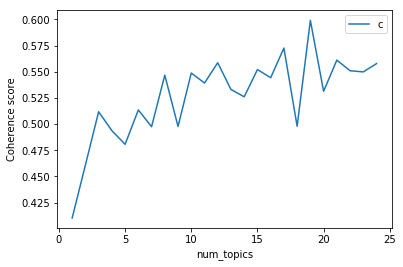

CPU times: user 3min 47s, sys: 9.62 s, total: 3min 56s
Wall time: 4min 16s


In [69]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary_filtered, corpus=corpus_filtered, texts=train_texts, limit=25)

In [71]:
print(c_v)
print(sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0])
pyLDAvis.gensim.prepare(lmlist[sorted(c_v.items(), key=operator.itemgetter(1), reverse=True)[0][0]], corpus_filtered, dictionary_filtered)

{0: 0.41035927907250913, 1: 0.46093644691209118, 2: 0.51177747526663153, 3: 0.49375148748544218, 4: 0.48067385740298363, 5: 0.51349006758227378, 6: 0.49747281872569543, 7: 0.54669667617709161, 8: 0.49772471345661073, 9: 0.54872640906304715, 10: 0.53921368853885032, 11: 0.55852982984109001, 12: 0.53303247852220914, 13: 0.52602763502703387, 14: 0.55203572502128007, 15: 0.54425164773909984, 16: 0.57254704510380994, 17: 0.49791997085614448, 18: 0.59901722839556126, 19: 0.53128054208746278, 20: 0.56108379142957143, 21: 0.55090581366797342, 22: 0.54981089437012276, 23: 0.55772032930260285}
18


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      11.359927        1       1  0.000304  0.033858
10     11.245788        1       2  0.079002  0.081392
17      8.798475        1       3 -0.104924  0.007733
8       8.339230        1       4 -0.013342  0.001757
9       8.085767        1       5  0.069392 -0.033093
13      6.977408        1       6 -0.050719  0.024485
15      5.901448        1       7 -0.035346  0.005998
7       5.454372        1       8 -0.000406  0.041581
4       4.141544        1       9 -0.009137 -0.038885
5       3.889012        1      10  0.057237 -0.044278
0       3.612518        1      11  0.041302 -0.014186
11      3.356665        1      12  0.053649 -0.036352
12      3.330323        1      13  0.011570  0.016721
16      3.017919        1      14 -0.024820 -0.052733
6       2.912694        1      15  0.010926  0.010957
14      2.901187        1      16  0.029297  0.017425
18      2.664765        1      17 -0.063009  0.014753
2       2.093785        1      18 -0.007247  0.001368
1       1.917173        1      19 -0.043729 -0.038502, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
181   Default  1361.000000               www  1361.000000  30.0000  30.0000
182   Default  1185.000000               gov  1185.000000  29.0000  29.0000
87    Default  1659.000000              item  1659.000000  28.0000  28.0000
93    Default  1961.000000              ltda  1961.000000  27.0000  27.0000
26    Default  1732.000000            edital  1732.000000  26.0000  26.0000
1306  Default  1045.000000            código  1045.000000  25.0000  25.0000
186   Default   918.000000              site   918.000000  24.0000  24.0000
320   Default  2208.000000             valor  2208.000000  23.0000  23.0000
187   Default   582.000000        comprasnet   582.000000  22.0000  22.0000
184   Default   872.000000            propor   872.000000  21.0000  21.0000
6     Default  2346.000000           federal  2346.000000  20.0000  20.0000
481   Default  3773.000000               art  3773.000000  19.0000  19.0000
973   Default   789.000000             siape   789.000000  18.0000  18.0000
5514  Default   914.000000     uniformização   914.000000  17.0000  17.0000
278   Default  1678.000000              cnpj  1678.000000  16.0000  16.0000
279   Default  1174.000000         contratar  1174.000000  15.0000  15.0000
317   Default  2081.000000               lei  2081.000000  14.0000  14.0000
803   Default   283.000000              vaga   283.000000  13.0000  13.0000
53    Default  1105.000000            pregão  1105.000000  12.0000  12.0000
204   Default   520.000000          site_www   520.000000  11.0000  11.0000
2450  Default   834.000000             turma   834.000000  10.0000  10.0000
272   Default  1103.000000          contrato  1103.000000   9.0000   9.0000
89    Default  1278.000000           empresa  1278.000000   8.0000   8.0000
205   Default   374.000000    comprasnet_gov   374.000000   7.0000   7.0000
17    Default   802.000000             cargo   802.000000   6.0000   6.0000
172   Default  1282.000000             total  1282.000000   5.0000   5.0000
2638  Default   652.000000           decisão   652.000000   4.0000   4.0000
582   Default  1181.000000               ser  1181.000000   3.0000   3.0000
161   Default  1441.000000           serviço  1441.000000   2.0000   2.0000
316   Default  1185.000000             legal  1185.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
184   Topic19    40.282964            propor   872.251518   0.8792  -5.1861
2679  Topic19     5.129793          advogado    60.067885   1.4939  -7.2469
188   Topic19    28.614946          abertura   591.843974   0.9250  -5.5281
199   Topic19    17.522698    licitar_edital   308.127846   1.0873  -6.0185
190   Topic

In [40]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = get_best_model_by_topics(corpus=corpus, dictionary=dictionary, limit=50, texts=train_texts)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
        print('Melhores 5 modelos', top_topics[:5])
    return lm, top_topics

In [36]:
logging.disable(level=logging.INFO)

In [41]:
%%time
lm, top_topics = ret_top_model()

/home/pedro/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:74: RuntimeWarning: invalid value encountered in double_scalars
  b = np.sum(gradf / q) / (1 / c + np.sum(1 / q))


Melhores 5 modelos [(5, 0.73169988798851271), (6, 0.71814579497499709), (3, 0.70086624055723812), (8, 0.69283338471343381), (16, 0.69105868521961733)]
Melhores 5 modelos [(1, 0.49153038747834793), (3, 0.44309482355181345), (0, 0.43110158015085565), (2, 0.40061933994606369), (4, 0.3110018845401829)]
Melhores 5 modelos [(4, 0.69710422491541302), (6, 0.69404891378665534), (8, 0.68678316062030731), (11, 0.67126412647894373), (5, 0.66767950243178775)]
Melhores 5 modelos [(0, 0.4885467543531396), (4, 0.41963539439982139), (2, 0.40061933994606358), (1, 0.35394331687792369), (3, 0.26719702343250151)]
Melhores 5 modelos [(6, 0.7830594008182562), (4, 0.71760172308584602), (11, 0.68522395617128784), (10, 0.67995211597921457), (5, 0.65671638010587141)]
Melhores 5 modelos [(1, 0.56142051842803409), (0, 0.44998082398855033), (3, 0.40061933994606358), (5, 0.36856048288168497), (2, 0.28381836930200388)]
Melhores 5 modelos [(8, 0.71590185433575781), (7, 0.71514098432779905), (6, 0.70801810375746099), (

KeyboardInterrupt: 

In [35]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[('proc_adv', 0.016016731893559868),
  ('incidente_uniformizacao', 0.012829814647509962),
  ('turma_recursal', 0.010936625295985868),
  ('inss_proc', 0.0091306983065047899),
  ('adv_procuradoria', 0.0090731010745261562),
  ('geral_federal', 0.0090731010745261562),
  ('parte_ora', 0.0089602210762516534),
  ('trata_agravo', 0.0087707625168775873),
  ('decisao_inadmitiu', 0.0086072663449699785),
  ('oab_requerido', 0.0083177163107341027)],
 [('comprasnet_gov', 0.027017224699846496),
  ('site_www', 0.02529700182894204),
  ('objeto_pregao', 0.018273239373618657),
  ('processo', 0.017400868819024449),
  ('abertura_propostas', 0.016551539482735283),
  ('propostas_partir', 0.016024489602518018),
  ('total_itens', 0.015450838906475283),
  ('edital_entrega', 0.01466498751076112),
  ('www_gov', 0.014505528771094914),
  ('licitados_edital', 0.01427815875000788)],
 [('codigo', 0.0098117947182114144),
  ('turma_recursal', 0.0092078500893413729),
  ('proc_adv', 0.0080897032116355461),
  ('incidente_

In [43]:
pyLDAvis.gensim.prepare(lm, corpus,       dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
4      5.002951        1       1 -0.390125 -0.036099
5      3.575705        1       2 -0.022637  0.180683
24     2.477793        1       3  0.070474 -0.029306
36     2.476030        1       4  0.018813  0.117893
72     2.272221        1       5  0.101304  0.005740
29     2.040274        1       6  0.096014 -0.055481
10     2.015970        1       7  0.034471 -0.017698
33     1.997512        1       8 -0.352434 -0.010864
76     1.812089        1       9  0.034875  0.042069
48     1.639230        1      10 -0.290535  0.037545
96     1.590694        1      11  0.071052 -0.017431
13     1.546939        1      12 -0.055480  0.005160
20     1.542378        1      13  0.061909  0.015141
78     1.526152        1      14  0.025200  0.002911
95     1.497165        1      15  0.064531 -0.012988
73     1.495734        1      16  0.016071  0.017601
85     1.432516        1      17  0.081672 -0.009027
8      1.396610        1      18 -0.280899  0.052196
46     1.390328        1      19  0.075234  0.148496
92     1.364753        1      20 -0.034771 -0.045221
63     1.350009        1      21  0.071802  0.019641
12     1.340904        1      22 -0.038872 -0.050807
15     1.314007        1      23  0.086328 -0.046006
83     1.296976        1      24  0.097731 -0.078775
55     1.276031        1      25 -0.172338  0.085062
31     1.249677        1      26  0.022550  0.039066
56     1.177628        1      27 -0.057871 -0.025176
90     1.165912        1      28  0.072910 -0.068320
47     1.158943        1      29  0.026099  0.115509
93     1.130407        1      30 -0.024427 -0.090750
...         ...      ...     ...       ...       ...
17     0.623098        1      71  0.068399  0.061484
39     0.611907        1      72 -0.008856  0.020029
40     0.599354        1      73  0.052906 -0.105208
97     0.578776        1      74  0.077977 -0.023870
57     0.552933        1      75  0.028425 -0.049248
58     0.552239        1      76 -0.019148 -0.091558
70     0.544983        1      77  0.084248  0.049683
7      0.544079        1      78 -0.120277 -0.099871
77     0.536104        1      79  0.034853 -0.021374
61     0.533028        1      80 -0.009357  0.045906
52     0.527977        1      81  0.030299  0.061488
38     0.517422        1      82 -0.013804  0.082175
79     0.505000        1      83 -0.145423  0.083312
18     0.490175        1      84 -0.052268 -0.078556
66     0.482309        1      85 -0.008728  0.021974
2      0.469946        1      86  0.033046  0.041294
9      0.462770        1      87 -0.183742  0.020642
25     0.443844        1      88  0.042634 -0.040058
11     0.432519        1      89  0.052711 -0.026380
37     0.432399        1      90  0.054880 -0.002248
87     0.432293        1      91  0.083387 -0.016078
0      0.426041        1      92  0.040855 -0.068819
30     0.413210        1      93 -0.041688 -0.027159
75     0.407997        1      94 -0.009008 -0.066735
91     0.401531        1      95  0.000840 -0.051953
82     0.396238        1      96  0.009260  0.087013
89     0.388531        1      97  0.039328 -0.077704
35     0.378135        1      98  0.045841  0.014267
32     0.285215        1      99  0.008807  0.011213
81     0.260842        1     100 -0.028100 -0.032002

[100 rows x 5 columns], topic_info=       Category         Freq                        Term        Total  \
term                                                                    
13572   Default   435.000000                  vigor_data   435.000000   
7919    Default   304.000000              quadro_pessoal   304.000000   
63      Default  1011.000000                        item  1011.000000   
583     Default  1776.000000                         art  1776.000000   
2767    Default   637.000000                      codigo   637.000000   
14098   Default   254.000000                 resolve_art   254.000000   
6561    De